In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd "drive/My Drive"

/content/drive/My Drive


In [0]:
#Bringing the data In
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testX.csv')
# lets convert train and test Id as indices
train_data_id = train_data.set_index('Id')
test_data_id = test_data.set_index('Id')

# lets split data into features ie X and ouputs ie Y
X = train_data_id.iloc[:,1:785]
#train_data_id.columns
Y = train_data_id.iloc[:,0]

In [0]:
#Spliting the data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size= 0.1, random_state=42)
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_std=False)
X_train =scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)

In [0]:
#Feature Extraction 
from sklearn.decomposition import PCA
pca = PCA()
X_r = pca.fit(X_train).transform(X_train)
sum_cum = np.cumsum(pca.explained_variance_ratio_)

In [7]:
for k in range(0,784):
  if sum_cum[k] >= 0.9:
    h = k
    break
  else:
    continue
h

83

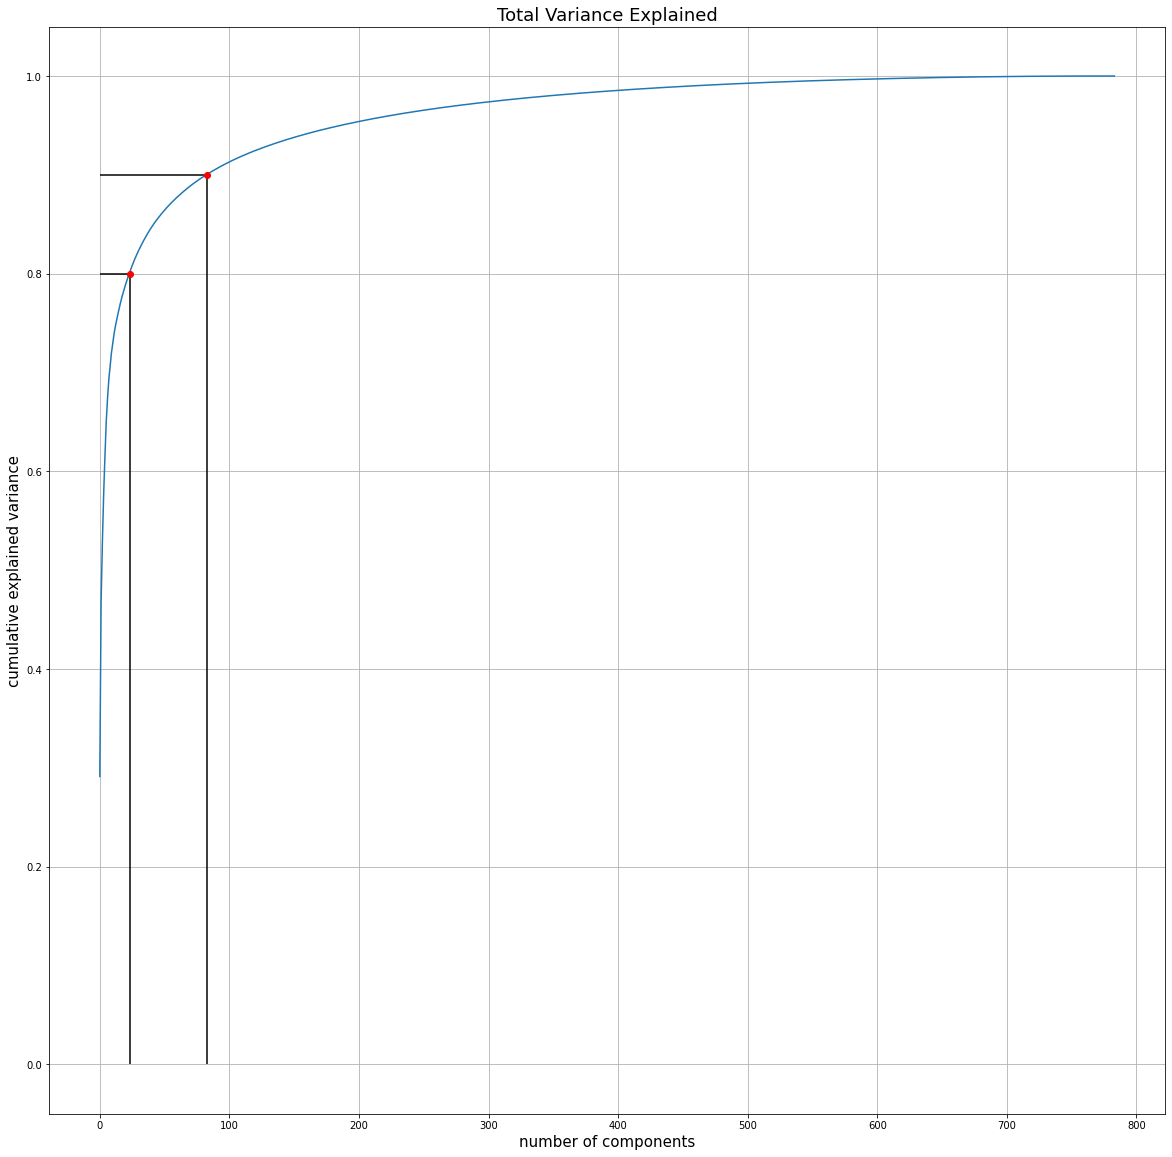

In [8]:
fig = plt.figure(figsize = (20,20))
plt.plot(sum_cum)
plt.plot(23,0.8 , '-ro')
plt.plot(83,0.9 , '-ro')
plt.hlines(y = 0.8, xmin = 0, xmax = 23)
plt.vlines(x = 23, ymin = 0, ymax = 0.8)
plt.hlines(y = 0.9, xmin = 0, xmax = 83)
plt.vlines(x = 83, ymin = 0, ymax = 0.9)
plt.xlabel('number of components',fontsize = 15)
plt.ylabel('cumulative explained variance',fontsize = 15)
plt.title("Total Variance Explained",fontsize = 18)
plt.grid()
plt.show()

In [9]:
sum_cum[23]

0.80117215106968

In [0]:
# PCA n_components = 85
pca_85 = PCA(n_components= 85)
X_train_85 = pca_85.fit(X_train).transform(X_train)
X_val_85 = pca_85.transform(X_val)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
def SVC_C_85(C):
  model = SVC(C)
  start = time.time()
  model.fit(X_train_85,y_train)
  end = time.time()
  start_1 = time.time()
  y_pred = model.predict (X_val_85)
  end_1 = time.time()
  y_pred_training = model.predict(X_train_85)
  accuracy = accuracy_score(y_val, y_pred)
  accuracy_training = accuracy_score(y_train, y_pred_training)
  print("Validation Accuracy : %f" % accuracy)
  print("Training Accuracy : %f" % accuracy_training)
  precision = precision_score(y_val, y_pred, average = 'micro')
  print('Precision: %f' % precision)
  recall = recall_score(y_val, y_pred, average = 'micro')
  print('Recall: %f' % recall)
  f1 = f1_score(y_val, y_pred, average = 'micro')
  print('F1 score: %f' % f1)
  print('Fitting Time: %f' % (end - start))
  print('Testing Time: %f' % (end_1 - start_1))
  ROC(y_val, y_pred)

In [0]:
def ROC(y_val, y_pred):
  
  n_classes = 5

  y_val = label_binarize(y_val, classes = [0,1,2,3,4])
  y_pred = label_binarize(y_pred, classes = [0,1,2,3,4])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  import itertools
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize = (10,6))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, linewidth=4,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

Validation Accuracy : 0.882833
Training Accuracy : 0.899481
Precision: 0.882833
Recall: 0.882833
F1 score: 0.882833
Fitting Time: 181.363138
Testing Time: 20.532239


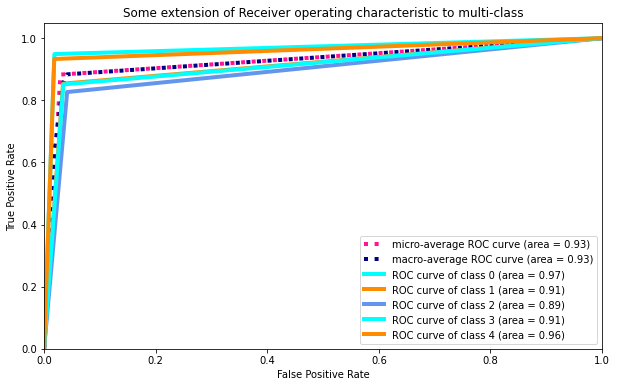

In [12]:
SVC_C_85(1)

Validation Accuracy : 0.896500
Training Accuracy : 0.950870
Precision: 0.896500
Recall: 0.896500
F1 score: 0.896500
Fitting Time: 172.122020
Testing Time: 16.352407


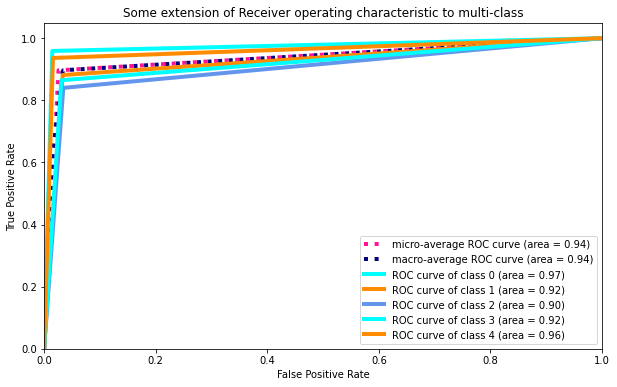

In [13]:
SVC_C_85(10)

Validation Accuracy : 0.889333
Training Accuracy : 0.991241
Precision: 0.889333
Recall: 0.889333
F1 score: 0.889333
Fitting Time: 353.293888
Testing Time: 15.437202


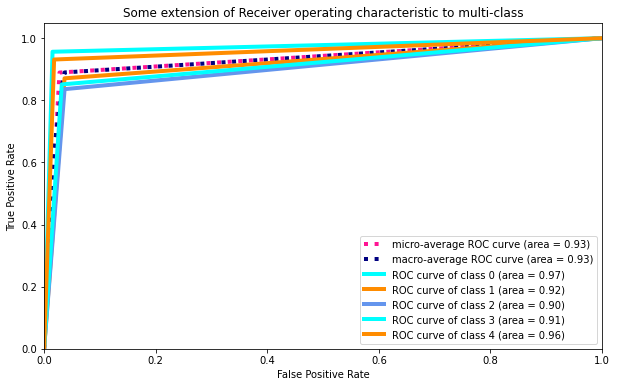

In [14]:
SVC_C_85(100)

Validation Accuracy : 0.897667
Training Accuracy : 0.965759
Precision: 0.897667
Recall: 0.897667
F1 score: 0.897667
Fitting Time: 214.283213
Testing Time: 15.849649


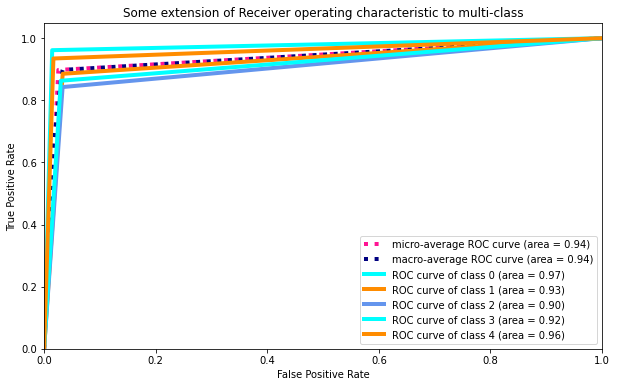

In [15]:
SVC_C_85(20)

Validation Accuracy : 0.893000
Training Accuracy : 0.973981
Precision: 0.893000
Recall: 0.893000
F1 score: 0.893000
Fitting Time: 234.289239
Testing Time: 15.452937


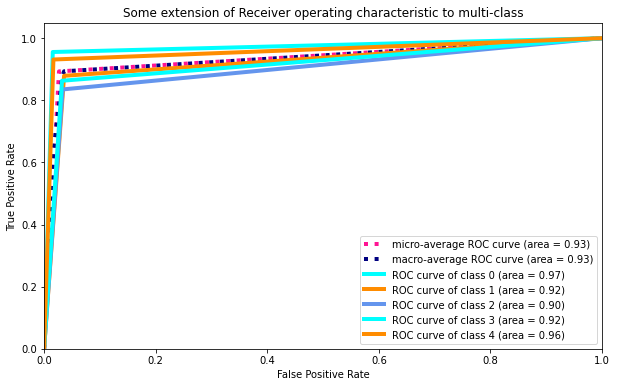

In [16]:
SVC_C_85(30)

Validation Accuracy : 0.892500
Training Accuracy : 0.978370
Precision: 0.892500
Recall: 0.892500
F1 score: 0.892500
Fitting Time: 266.180354
Testing Time: 15.362403


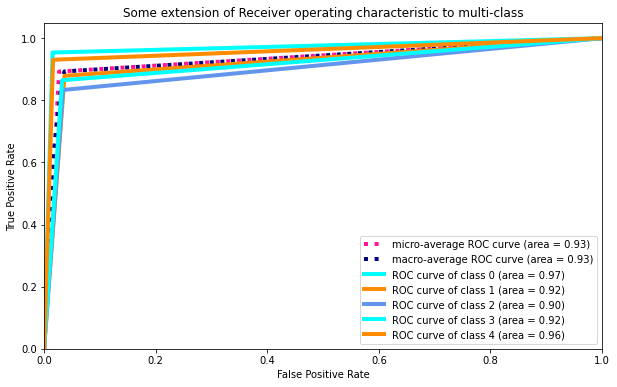

In [17]:
SVC_C_85(40)

Validation Accuracy : 0.894000
Training Accuracy : 0.982593
Precision: 0.894000
Recall: 0.894000
F1 score: 0.894000
Fitting Time: 271.819004
Testing Time: 15.236524


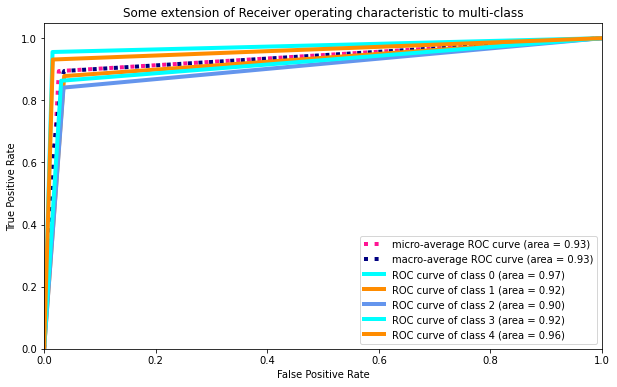

In [18]:
SVC_C_85(50)

Validation Accuracy : 0.895000
Training Accuracy : 0.985111
Precision: 0.895000
Recall: 0.895000
F1 score: 0.895000
Fitting Time: 276.236632
Testing Time: 15.565153


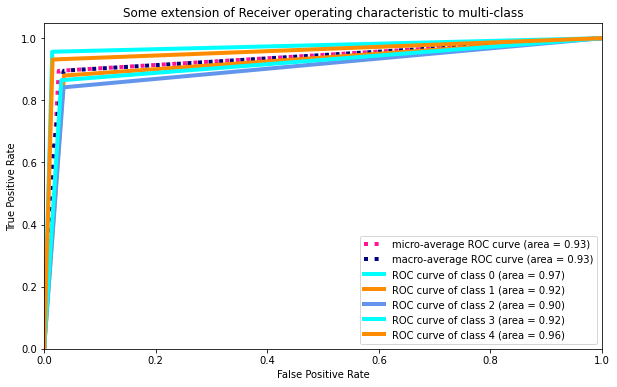

In [19]:
SVC_C_85(60)

Validation Accuracy : 0.894333
Training Accuracy : 0.986926
Precision: 0.894333
Recall: 0.894333
F1 score: 0.894333
Fitting Time: 293.043278
Testing Time: 15.341374


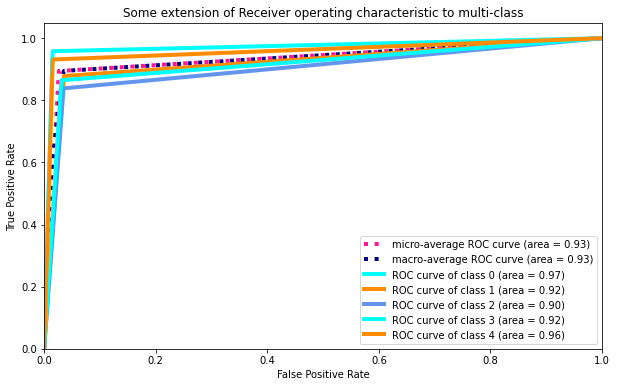

In [20]:
SVC_C_85(70)

Validation Accuracy : 0.893000
Training Accuracy : 0.988648
Precision: 0.893000
Recall: 0.893000
F1 score: 0.893000
Fitting Time: 309.811753
Testing Time: 15.414913


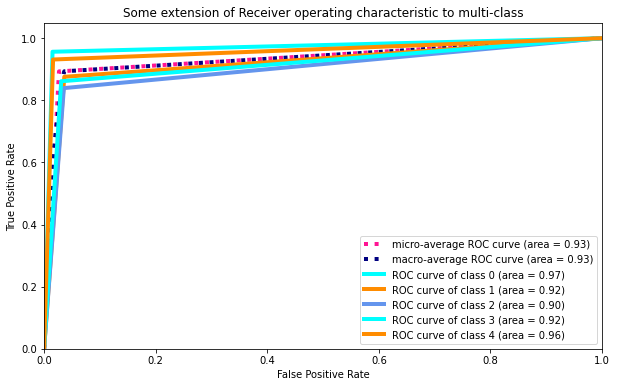

In [21]:
SVC_C_85(80)

Validation Accuracy : 0.890667
Training Accuracy : 0.989981
Precision: 0.890667
Recall: 0.890667
F1 score: 0.890667
Fitting Time: 309.442480
Testing Time: 15.208403


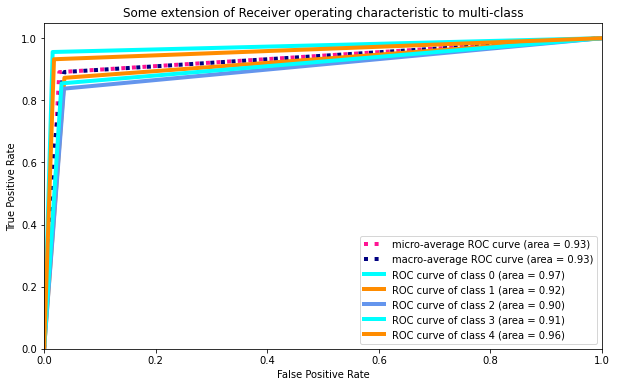

In [22]:
SVC_C_85(90)

Validation Accuracy : 0.897333
Training Accuracy : 0.956741
Precision: 0.897333
Recall: 0.897333
F1 score: 0.897333
Fitting Time: 168.884361
Testing Time: 16.193885


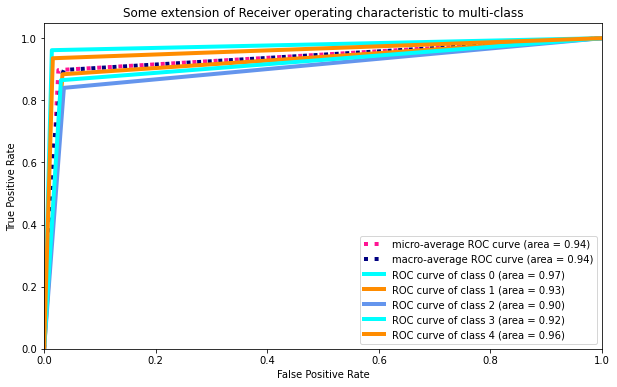

In [23]:
SVC_C_85(13)

Validation Accuracy : 0.897833
Training Accuracy : 0.959741
Precision: 0.897833
Recall: 0.897833
F1 score: 0.897833
Fitting Time: 177.761742
Testing Time: 16.065955


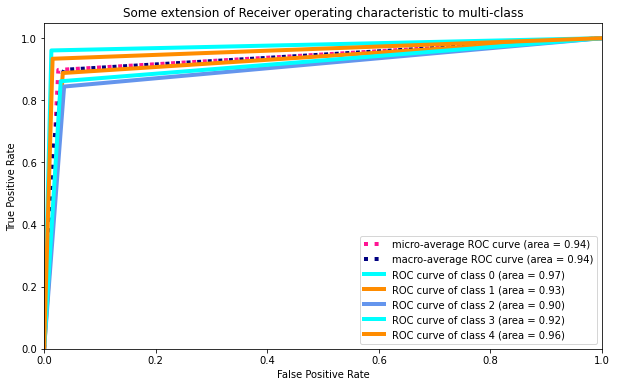

In [24]:
SVC_C_85(15)

Validation Accuracy : 0.897167
Training Accuracy : 0.962481
Precision: 0.897167
Recall: 0.897167
F1 score: 0.897167
Fitting Time: 174.753152
Testing Time: 16.108961


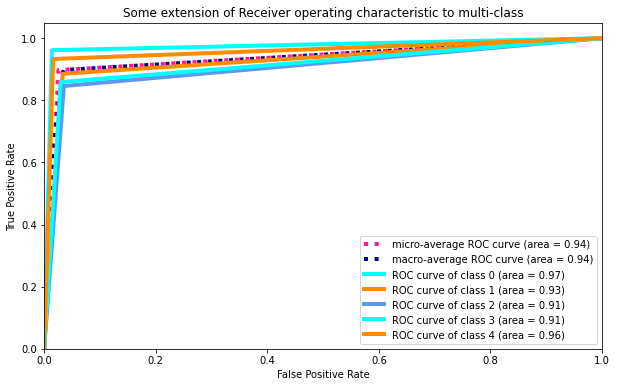

In [25]:
SVC_C_85(17)

Validation Accuracy : 0.897500
Training Accuracy : 0.964926
Precision: 0.897500
Recall: 0.897500
F1 score: 0.897500
Fitting Time: 193.691342
Testing Time: 15.881908


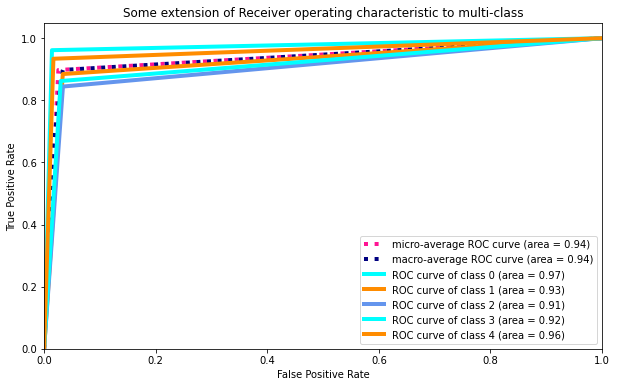

In [26]:
SVC_C_85(19)

In [0]:
fea = []
for i in range(1,785):
  fea.append(str(i))
X = pd.read_csv('train_p1.csv', usecols = fea)
y = pd.read_csv('train_p1.csv', usecols= ['Label'])

In [28]:
#Training the model on best parameter that is C= 13 for n_component = 85
scalar = StandardScaler(with_std=False)
X =scalar.fit_transform(X)
pca = PCA(n_components= 85)
X = pca.fit_transform(X)
model = SVC(15)
model.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
test_fea = [str(i) for i in range(0,784)]
X_test_t = pd.read_csv('testX_p1.csv', usecols=test_fea)

In [0]:
X_test_t = scalar.transform(X_test_t)
X_test_t = pca.transform(X_test_t)

In [0]:
y_pred_t = model.predict(X_test_t)

In [0]:
id = [i for i in range(0,10000)]
frame = pd.DataFrame(id, columns=['Id'])

In [0]:
frame['Label'] = y_pred_t

In [0]:
frame

,Id,Label
0,0,4
1,1,4
2,2,1
3,3,1
4,4,1
...,...,...
9995,9995,1
9996,9996,1
9997,9997,3
9998,9998,2


In [0]:
frame.to_csv(r'submission_p1_SVM_c_15_n_85.csv', index = False)

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!kaggle competitions submit -c ece-657a-w20-asg3-part-1 -f submission_p1_SVM_c_13_n_85.csv -m "Part 1 with C=15 and n_components = 85"

100% 67.3k/67.3k [00:00<00:00, 96.2kB/s]
Successfully submitted to ECE 657A W20 - Asg3 - Part 1